In [6]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM
import cv2

In [7]:
def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")


def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)


def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for i, mask_np in enumerate(masks):
        axes[i + 1].imshow(mask_np, cmap="gray")
        axes[i + 1].set_title(f"Mask {i+1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis("off")

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(
            logit.item(), 2
        )  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle(
            (x_min, y_min),
            box_width,
            box_height,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(
            x_min,
            y_min,
            f"Confidence: {confidence_score}",
            fontsize=8,
            color="red",
            verticalalignment="top",
        )

    plt.show()


def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")


def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")


def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")


def add_padding_and_display(image, box, padding_ratio=0.1):
    """
    Adds a specified percentage of padding to the bounding box, crops the image to this padded box,
    and displays the cropped image. Ensures padding does not extend beyond image bounds.

    :param image: The image as a PIL Image or numpy array.
    :param box: The bounding box as a tuple (x_min, y_min, x_max, y_max).
    :param padding_ratio: The ratio of padding to add to each side of the box (default is 10% or 0.1).
    
    :return: The cropped image as a PIL Image.
    """
    # Determine image dimensions
    if isinstance(image, Image.Image):
        width, height = image.size
    elif isinstance(image, np.ndarray):
        height, width, _ = image.shape
        image = Image.fromarray(image)
    else:
        raise ValueError("Image must be a PIL Image or numpy array.")

    # Unpack the bounding box and calculate padding
    x_min, y_min, x_max, y_max = box
    pad_width = (x_max - x_min) * padding_ratio
    pad_height = (y_max - y_min) * padding_ratio

    # Apply padding, ensuring coordinates remain within image bounds
    x_min_padded = max(0, int(x_min - pad_width))
    y_min_padded = max(0, int(y_min - pad_height))
    x_max_padded = min(width, int(x_max + pad_width))
    y_max_padded = min(height, int(y_max + pad_height))

    # Crop and display the image
    cropped_image = image.crop((x_min_padded, y_min_padded, x_max_padded, y_max_padded))
    
    return cropped_image

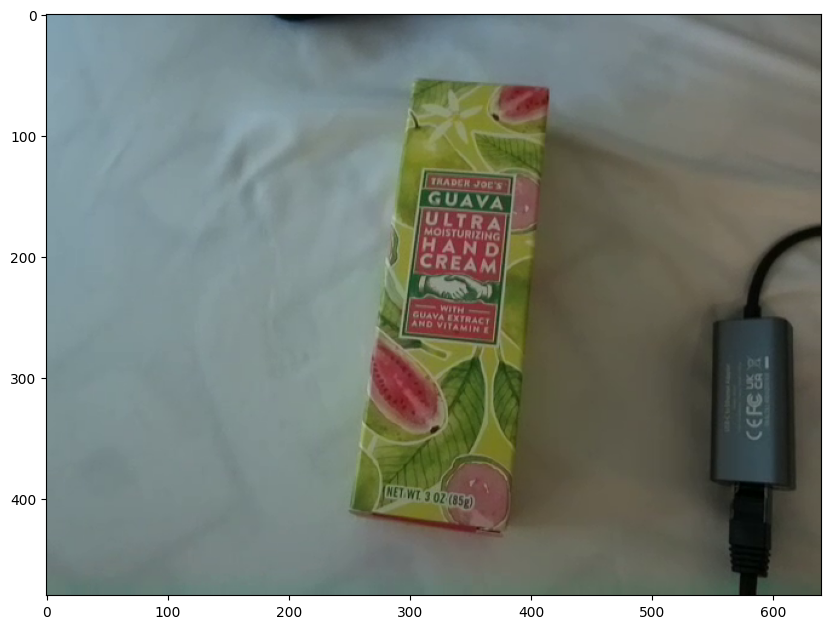

In [8]:
text_prompt = "Where can I buy this hand cream?"
image = 'images/video6/frame_0009.png'

image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [9]:
from PIL import Image

In [10]:
model = LangSAM(sam_type='vit_b')
image_pil = Image.fromarray(image)
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

LocalEntryNotFoundError: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache. Please check your connection and try again or make sure your Internet connection is on.

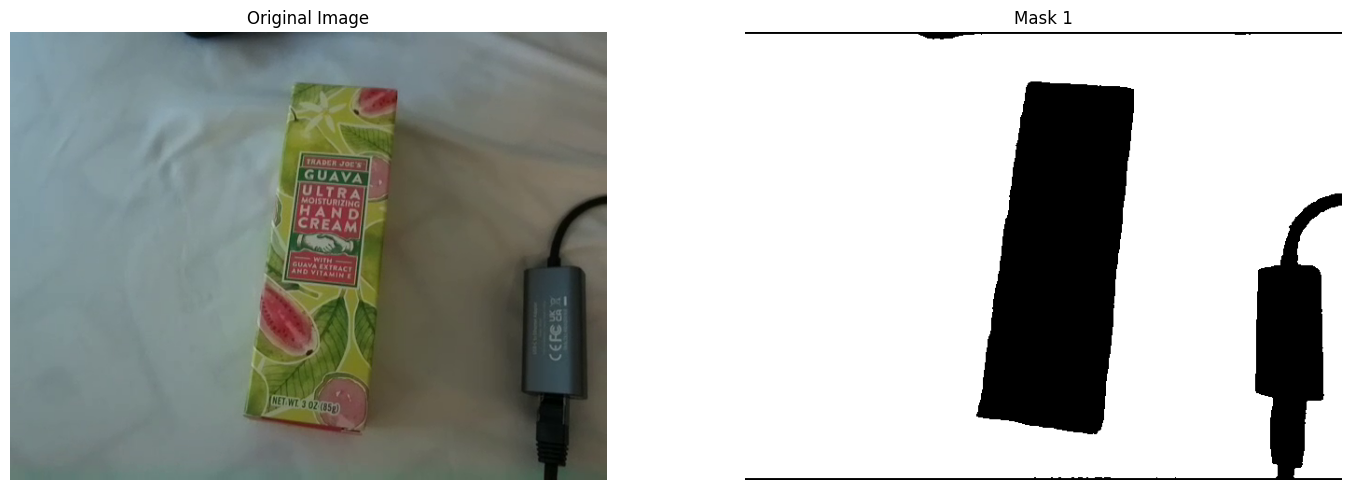

In [ ]:
masks_np = [mask.squeeze().cpu().numpy() for mask in masks]
display_image_with_masks(image_pil, masks_np)

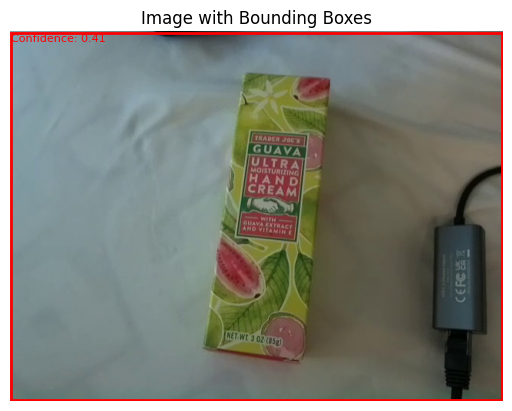

In [ ]:
display_image_with_boxes(image_pil, boxes, logits)

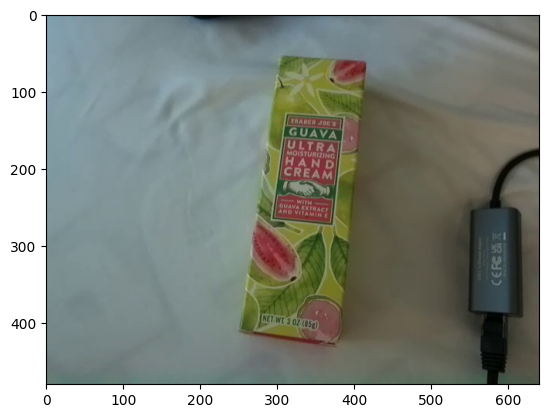

In [ ]:
image = add_padding_and_display(image_pil, boxes[0])
plt.imshow(image)